# **1. Libraries**

In [ ]:
import os
import random
import glob
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tabulate import tabulate

from skimage import data, io, filters

from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense
from keras import applications
from tensorflow.keras.optimizers import Adam, Adamax
import tensorflow as tf

import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

#import joblib as joblib
#!pip install onnx
#!pip install onnx onnx-tf

# **1.1 Data Validation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gc.collect()

2011

In [ ]:
data_dir = ('/content/drive/MyDrive/Garbage classification')
transformer = T.Compose([T.Resize((32, 32)), T.ToTensor()])
dataset = ImageFolder(data_dir, transform = transformer)
print(dataset.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


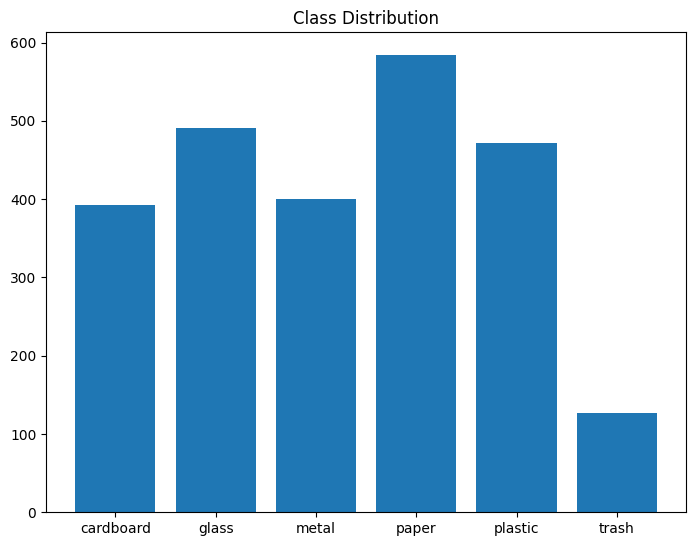

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
counts = [393,491,400,584,472,127]
ax.bar(dataset.classes,counts)
plt.title('Class Distribution')
plt.show()

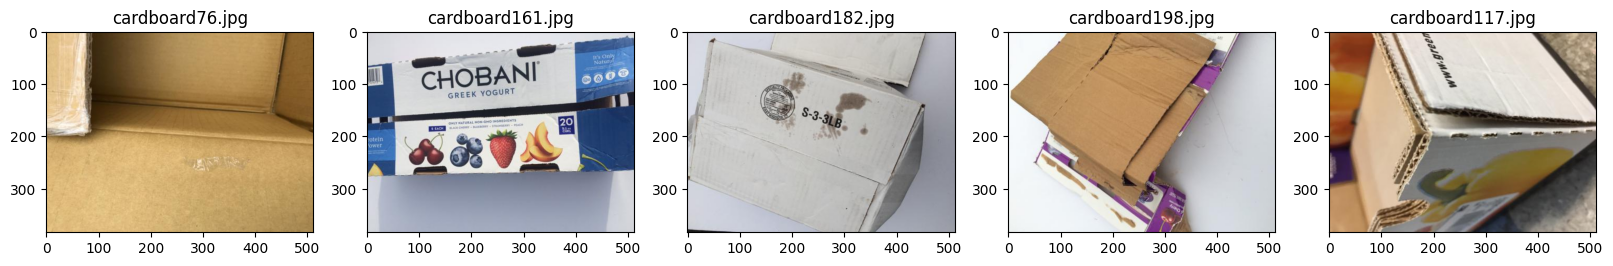

In [ ]:
random.seed(10)
plt.figure(figsize=(20,20))

cardboard_folder = ("/content/drive/MyDrive/Garbage classification/cardboard")
for i in range(5):
  file = random.choice(os.listdir(cardboard_folder))
  image_path = os.path.join(cardboard_folder, file)
  img = mpimg.imread(image_path)
  ax = plt.subplot(1, 5, i + 1)
  plt.imshow(img)
  ax.title.set_text(file)
  plt.imshow(img)

In [ ]:
transformation = T.Compose([
    T.Resize((256,256)),
    T.ToTensor()
])
dataset = ImageFolder(data_dir, transform=transformation)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

Text(0, 0.5, 'population')

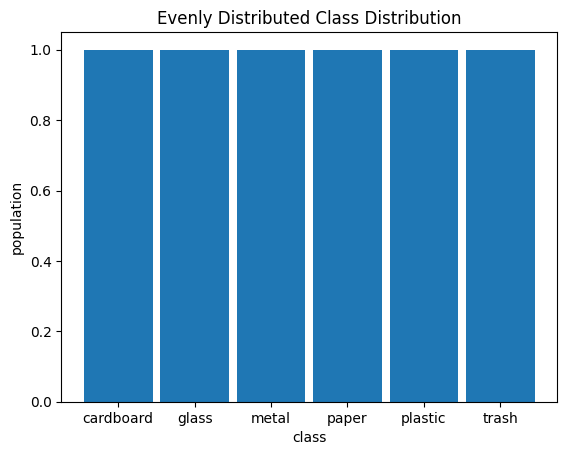

In [ ]:
plt.hist(dataset.classes, bins=np.arange(7)-0.5, rwidth=0.9)
plt.title('Evenly Distributed Class Distribution')
plt.xlabel('class')
plt.ylabel('population')

# **2. Data Preprocessing**

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def accuracy_count(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_steps(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_steps(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy_count(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

class ResNet(ImageClassificationBase):
    def __init__(self, dataset):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return self.network(xb)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
      return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# **3. Data Training**


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_steps(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        model.train()
        train_losses = []

        for batch in train_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            loss = model.training_steps((images, labels))
            train_losses.append(loss)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()

        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [ ]:
device = get_default_device()
model = to_device(ResNet(dataset), device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.0MB/s]


In [ ]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5
history_adam = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.8090, val_loss: 0.3520, val_acc: 0.9184
Epoch [1], train_loss: 0.1807, val_loss: 0.2376, val_acc: 0.9375
Epoch [2], train_loss: 0.0582, val_loss: 0.1926, val_acc: 0.9444
Epoch [3], train_loss: 0.0272, val_loss: 0.1619, val_acc: 0.9618
Epoch [4], train_loss: 0.0273, val_loss: 0.2693, val_acc: 0.9201
Epoch [5], train_loss: 0.0305, val_loss: 0.2272, val_acc: 0.9392
Epoch [6], train_loss: 0.0394, val_loss: 0.2553, val_acc: 0.9080
Epoch [7], train_loss: 0.0218, val_loss: 0.1924, val_acc: 0.9392


In [ ]:
opt_func = torch.optim.Adam
history_adamax = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.0304, val_loss: 0.2263, val_acc: 0.9306
Epoch [1], train_loss: 0.0219, val_loss: 0.2625, val_acc: 0.9149
Epoch [2], train_loss: 0.0328, val_loss: 0.3952, val_acc: 0.9184
Epoch [3], train_loss: 0.0199, val_loss: 0.4933, val_acc: 0.8646
Epoch [4], train_loss: 0.0202, val_loss: 0.3407, val_acc: 0.9184
Epoch [5], train_loss: 0.0214, val_loss: 0.2499, val_acc: 0.9549
Epoch [6], train_loss: 0.0123, val_loss: 0.3204, val_acc: 0.9271
Epoch [7], train_loss: 0.0099, val_loss: 0.2731, val_acc: 0.9323


In [ ]:
evaluate(model, train_dl)

{'val_loss': 0.0035440539941191673, 'val_acc': 0.9987499713897705}

# **4. Training Evaluation**

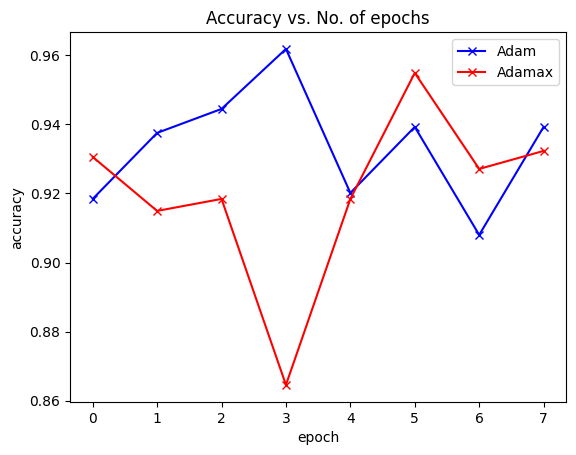

In [ ]:
def plot_comparisson(history_adam, history_adamax):
  accuracies_adam = [x['val_acc'] for x in history_adam]
  accuracies_adamax = [x['val_acc'] for x in history_adamax]
  plt.plot(accuracies_adam, '-bx', label='Adam')
  plt.plot(accuracies_adamax, '-rx', label='Adamax')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs');
  plt.legend()

plot_comparisson(history_adam, history_adamax)

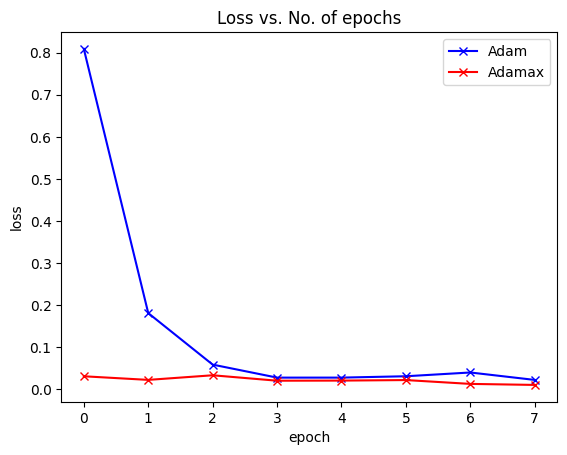

In [ ]:
def plot_losses_comparisson(history_adam, history_adamax):
  train_losses_adam = [x.get('train_loss') for x in history_adam]
  train_losses_adamax = [x.get('train_loss') for x in history_adamax]
  plt.plot(train_losses_adam, '-bx', label='Adam')
  plt.plot(train_losses_adamax, '-rx', label='Adamax')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Loss vs. No. of epochs');
  plt.legend()

plot_losses_comparisson(history_adam, history_adamax)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


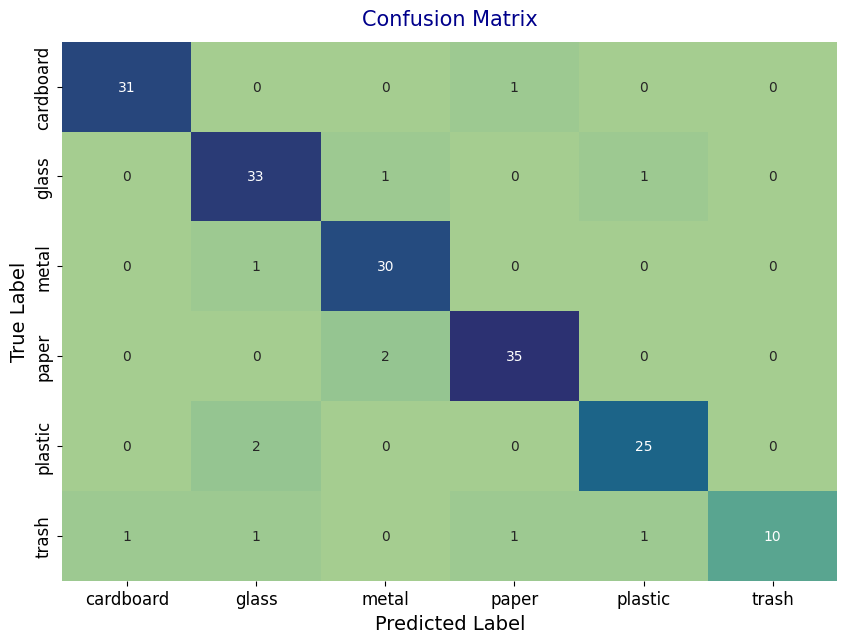

Classification Report
              precision    recall  f1-score   support

   cardboard       0.97      0.97      0.97        32
       glass       0.89      0.94      0.92        35
       metal       0.91      0.97      0.94        31
       paper       0.95      0.95      0.95        37
     plastic       0.93      0.93      0.93        27
       trash       1.00      0.71      0.83        14

    accuracy                           0.93       176
   macro avg       0.94      0.91      0.92       176
weighted avg       0.93      0.93      0.93       176



In [ ]:
def get_predictions(loader, model, device):
    """Get predictions from the model for the validation set."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

y_pred, y_true = get_predictions(val_dl, model, device)

cm = confusion_matrix(y_true, y_pred)

matrix = pd.DataFrame(cm, index=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
                      columns=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])

plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(matrix, annot=True, fmt='d', cmap='crest', cbar=False)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), fontsize=12)
plt.title('Confusion Matrix', fontsize=15, pad=12, color='darkblue')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.show()

target_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

# **Result**

In [ ]:
def predict_image(img, model):
  xb = to_device (img.unsqueeze(0), device)
  yb = model(xb)
  prob, preds = torch.max(yb, dim=1)
  return dataset.classes[(preds[0].item())]

Label:  metal , Predicted: metal


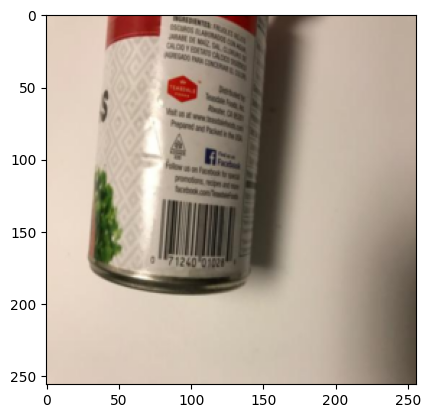

In [ ]:
img, label = test_ds[10]
plt.imshow(img.permute(1,2,0))
print('Label: ', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
#joblib.dump(model, 'model.pkl')
torch.save(model.state_dict(), 'model.pth')